In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools #para loops mas eficientes
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn import preprocessing

# Análisis exploratorio de datos  
Como en todo proyecto que utiliza datos, primero debemos de limpiarlos y hacer un pequeño análisis exploratorio para familiarizarnos con nuestros datos.

In [2]:
application_record=pd.read_csv('application_record.csv')
credit_record=pd.read_csv('credit_record.csv')
application_record_int=pd.read_csv('application_record_int.csv')

In [3]:
application_record_int.head()

,ID,CODE_GENDER_INT,FLAG_OWN_CAR_INT,FLAG_OWN_REALTY_INT,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE_INT,AME_EDUCATION_TYPE_INT,NAME_FAMILY_STATUS_INT,NAME_HOUSING_TYPE_INT,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE_INT,CNT_FAM_MEMBERS
0,5008804,1,1,1,0,427500.0,5,2,1,5,-12005,-4542,1,1,0,0,NaN,2
1,5008805,1,1,1,0,427500.0,5,2,1,5,-12005,-4542,1,1,0,0,NaN,2
2,5008806,1,1,1,0,112500.0,5,5,2,2,-21474,-1134,1,0,0,0,17.0,2
3,5008808,2,2,1,0,270000.0,1,5,4,2,-19110,-3051,1,0,1,1,15.0,1
4,5008809,2,2,1,0,270000.0,1,5,4,2,-19110,-3051,1,0,1,1,15.0,1


# Análsis para application records

In [4]:
application_record.shape

(438556, 18)

In [5]:
application_record['ID'].nunique()-application_record.shape[0]

-46

Encontramos que existen 46 entradas duplicadas dentro de la llave identificadora ID. En este caso consideramos estos elementos repetidos como un error en los datos, pues dada la estructura de la tabla application_record este duplicado en el elemento llave ID nos dice que este error se deba probablemente a un error en la entrada de los datos. Se recomienda compartir estos hallazgos con el área correspondiente para asignarle una llave única a cada cliente y además revisar el procesos de apertura y creación de aplicaciones  para asegurarnos de que esto no vuelva a ocurrir con ningún otro nuevo cliente!

In [6]:
application_record.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS          int64
dtype: object

In [7]:
application_record.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134202
CNT_FAM_MEMBERS             0
dtype: int64

In [8]:
application_record.isnull().sum()/application_record.shape[0]

ID                     0.000000
CODE_GENDER            0.000000
FLAG_OWN_CAR           0.000000
FLAG_OWN_REALTY        0.000000
CNT_CHILDREN           0.000000
AMT_INCOME_TOTAL       0.000000
NAME_INCOME_TYPE       0.000000
NAME_EDUCATION_TYPE    0.000000
NAME_FAMILY_STATUS     0.000000
NAME_HOUSING_TYPE      0.000000
DAYS_BIRTH             0.000000
DAYS_EMPLOYED          0.000000
FLAG_MOBIL             0.000000
FLAG_WORK_PHONE        0.000000
FLAG_PHONE             0.000000
FLAG_EMAIL             0.000000
OCCUPATION_TYPE        0.306009
CNT_FAM_MEMBERS        0.000000
dtype: float64

Nótese que nos faltan alrededor del 30% de los datos en la columna de OCCUPATION_TYPE, mientras que todas las otras columnas se encuentran completas. Entremos ahora más a detalle en análisis de la columna OCCUPATION_TYPE para identificar posibles soluciones para los datos faltantes.

<AxesSubplot:>

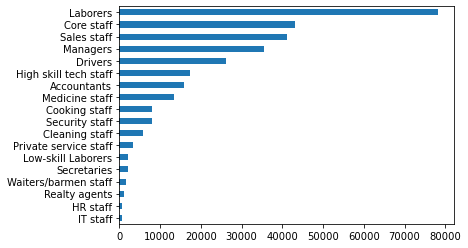

In [9]:
application_record['OCCUPATION_TYPE'].value_counts().sort_values().plot(kind="barh")

# Análsis para credit record

In [10]:
credit_record.shape

(1048575, 3)

In [11]:
credit_record.dtypes

ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

In [12]:
credit_record.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

Afortunadamente para la tabla credit_record encontramos que no existe ningun valor nulo y por lo tanto no sera necesario buscar aplicar alguna técnica de imputación de datos.

In [13]:
credit_record['STATUS'].value_counts()/credit_record.shape[0]*100

C    42.155401
0    36.537205
X    19.953747
1     1.057626
5     0.161457
2     0.082779
3     0.030518
4     0.021267
Name: STATUS, dtype: float64

# KPI´s


In [14]:
KPI=pd.DataFrame()

In [15]:
#Hacemos un pivote de credit_record para poder trabajar con los datos en el tiempo mas facil e intuitivamente.
credit_record2=credit_record.pivot(index='ID', columns='MONTHS_BALANCE', values='STATUS')
credit_record2.head()


MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,X
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,C,C,C,C,C,C,C,C,C
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001715,NaN,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X


In [16]:
#Creamos otro pivote en la tabla para agroupar la suma de nuestros atributos por mes.
credit_record_count=credit_record2.apply(pd.Series.value_counts, axis=0)
credit_record_count

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
0,230.0,538.0,850.0,1120.0,1416.0,1719.0,1947.0,2223.0,2496,2769,...,9566,9752,10062,10279,10568,10491,10610,10398,10301,8914
1,NaN,3.0,11.0,17.0,28.0,37.0,46.0,56.0,66,74,...,269,300,305,309,316,379,313,367,372,309
2,NaN,NaN,NaN,NaN,2.0,1.0,2.0,6.0,5,10,...,21,24,15,19,20,21,31,19,17,19
3,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,2,2,...,7,7,9,7,9,5,6,11,6,6
4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,1,...,4,4,6,8,9,8,5,3,11,5
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,4,...,46,42,44,48,54,54,54,57,62,65
C,1.0,9.0,24.0,52.0,91.0,148.0,230.0,318.0,435,558,...,14422,14811,15220,15630,16015,16403,16784,17139,17504,17613
X,184.0,270.0,370.0,460.0,572.0,671.0,800.0,891.0,1017,1157,...,5937,5944,5979,5996,5890,6004,6051,6215,6163,6925


# Índice de pagos vencidos  
Definimos el índice de pagos vencidos ( IPV) como la proporción de clientes que cuentan con un crédito vencido  o incobrable entre el total de los clientes que cuentan con un préstamo activo. Esta medida clave refleja la calidad en las medidas de manejo de crédito y las medias de aceptación de crédito en nuestra institución.       
Se expresa como porcentaje.  
Para esto definimos un a credito vencido como todo aquel que presenta un estado 5 en la columna "STATUS"
  
$ \Huge {IPV=\frac{\Sigma  \, Créditos \;  vencidos}{\Sigma  \, Créditos  \; activos}} $


In [17]:
#Definimos el indice de pagos vencidos como el 
def indice_pago_vencido(column):
    sum_credito_act=column.iloc[0:7].sum() #Sumamos los estados con credito activo
    indice=column.iloc[5]/sum_credito_act*100 #buscamos los creditos con STATUS=5 que son creditos vencidos
    return indice
    
    

In [18]:
#calculamos los kpis por mes
indice_pago_vencido(credit_record_count)

MONTHS_BALANCE
-60         NaN
-59         NaN
-58         NaN
-57         NaN
-56         NaN
         ...   
-4     0.197361
-3     0.194224
-2     0.203615
-1     0.219290
 0     0.241358
Length: 61, dtype: float64

In [19]:
#guardamos los kpis por mes
KPI['IPV']=indice_pago_vencido(credit_record_count)
KPI

,IPV
MONTHS_BALANCE,
-60,NaN
-59,NaN
-58,NaN
-57,NaN
-56,NaN
...,...
-4,0.197361
-3,0.194224
-2,0.203615


# Índice de pagos tardíos  
Índice de pagos tardíos: Similar al IPV, definimos al Índice de pagos tardíos (IPT) como la proporción de clientes que cuentan con un crédito con pagos retrasado, pero NO incobrable entre el total de clientes que cuentan con un préstamo activo. Esta medida clave, al igual que el IPV, nos habla de la salud en general de nuestros procesos de apertura de crédito, pero además nos brinda información sobre el flujo de dinero en las cuentas por cobrar y puede ser utilizada por el área de cobranza para establecer metas.    
Se expresa como porcentaje.  
Para esto definimos un credito vencido como todo aquel que presenta un estado (1,2,3,4,5,0) en la columna "STATUS"  

$ \Huge {IPT=\frac{\Sigma  \, Créditos \;  tardíos}{\Sigma  \, Créditos  \; activos}} $

In [20]:
#Definimos el indice de pagos tardios 
def indice_pago_tard(column):
    sum_credito_act=column.iloc[0:7].sum() #Sumamos los estados con credito activo
    sum_tard=column.iloc[0:5].sum() #sumamos los estados tardios (1,2,3,4,0)
    indice=sum_tard/sum_credito_act*100 #formula por 100 para tener un porcentaje
    return indice
    
    

In [21]:
# debug nueva funcion IPT
indice_pago_tard(credit_record_count)

MONTHS_BALANCE
-60    99.567100
-59    98.363636
-58    97.288136
-57    95.626577
-56    94.079375
         ...    
-4     39.852345
-3     39.438190
-2     38.572551
-1     37.870053
 0     34.358175
Length: 61, dtype: float64

In [22]:
KPI['IPT']=indice_pago_tard(credit_record_count)
KPI.tail()

,IPV,IPT
MONTHS_BALANCE,,
-4,0.197361,39.852345
-3,0.194224,39.438190
-2,0.203615,38.572551
-1,0.219290,37.870053
0,0.241358,34.358175


# Edad promedio de crédito tardío
Edad promedio de crédito tardío: Se define como el tiempo promedio de retraso en días de los créditos tardíos, pero no vencidos. Para esta función obtenemos el promedio de los estados tardíos (0,1,2,3,4) y dividimos entre el número total de créditos activos. Para poder trabajar con datos categóricos le aplicaremos la técnica “Midpoint Coding”, es decir: asignaremos el punto medio de cada categoría como su valor numérico.  
* 0:1-29 -> 15  
* 30-59 -> 45
* ... 

Se expresa como un rango de 30 días

$ \Huge {EPCT=\frac{\Sigma  \, Estados \;  tardíos}{\Sigma  \, Créditos  \; activos}} $

In [23]:
#para poder calcular el promedio de una variable categorica vamos a utilizar la técnica "Midpoint Coding"
estados=[15.0, 45.0, 75.0, 105.0, 135.0]
estados

[15.0, 45.0, 75.0, 105.0, 135.0]

In [24]:
#esta multiplicación por elemento en la matriz nos premite calcular la suma de la codificacion de nuestras variables categóricas
# de una forma computacional mas barata
credit_record_count.iloc[0:5].mul(estados, axis=0)

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
0,3450.0,8070.0,12750.0,16800.0,21240.0,25785.0,29205.0,33345.0,37440.0,41535.0,...,143490.0,146280.0,150930.0,154185.0,158520.0,157365.0,159150.0,155970.0,154515.0,133710.0
1,NaN,135.0,495.0,765.0,1260.0,1665.0,2070.0,2520.0,2970.0,3330.0,...,12105.0,13500.0,13725.0,13905.0,14220.0,17055.0,14085.0,16515.0,16740.0,13905.0
2,NaN,NaN,NaN,NaN,150.0,75.0,150.0,450.0,375.0,750.0,...,1575.0,1800.0,1125.0,1425.0,1500.0,1575.0,2325.0,1425.0,1275.0,1425.0
3,NaN,NaN,NaN,NaN,NaN,210.0,210.0,105.0,210.0,210.0,...,735.0,735.0,945.0,735.0,945.0,525.0,630.0,1155.0,630.0,630.0
4,NaN,NaN,NaN,NaN,NaN,NaN,135.0,NaN,135.0,135.0,...,540.0,540.0,810.0,1080.0,1215.0,1080.0,675.0,405.0,1485.0,675.0


In [25]:
#Calculamos el KPI
numerador=credit_record_count.iloc[0:5].mul(estados, axis=0).sum() # sumamos lso estados tardios
denominador=credit_record_count.iloc[0:5].sum() #obtenemos el total de creditos tarios
EPCT=numerador/denominador
KPI['EPCT']=EPCT
KPI.tail()

,IPV,IPT,EPCT
MONTHS_BALANCE,,,
-4,0.197361,39.852345,16.287601
-3,0.194224,39.438190,16.129959
-2,0.203615,38.572551,16.250232
-1,0.219290,37.870053,16.311292
0,0.241358,34.358175,16.248244


# Índice de exito en las medidas de colleción
índice de éxito en las medidas de colección: Se define como proporción de créditos que son saldados este mes entre el total de créditos vencidos y tardíos. Nos ayuda a entender que tan efectivas son nuestras medidas de colección de deuda para identificar posibles mejoras.

Se expresa como un rango de 30 días

$ \Huge {IEMC=\frac{\Sigma  \, Creditos \;  saldados}{\Sigma  \, Créditos  \; activos}} $

In [27]:
def indice_exito_pago(column):
    sum_credito_act=column.iloc[0:7].sum() #Sumamos los estados con credito activo
    sum_tard=column.iloc[6:7].sum() #sumamos los estados saldados (c)
    indice=sum_tard/sum_credito_act*100 #formula por 100 para tener un porcentaje
    return indice
    

In [28]:
#calculamos el indice para cada mes
indice_exito_pago(credit_record_count)

MONTHS_BALANCE
-60     0.432900
-59     1.636364
-58     2.711864
-57     4.373423
-56     5.920625
         ...    
-4     59.950294
-3     60.367586
-2     61.223834
-1     61.910657
 0     65.400468
Length: 61, dtype: float64

In [29]:
KPI['IEMC']=indice_exito_pago(credit_record_count)
KPI.tail()

,IPV,IPT,EPCT,IEMC
MONTHS_BALANCE,,,,
-4,0.197361,39.852345,16.287601,59.950294
-3,0.194224,39.438190,16.129959,60.367586
-2,0.203615,38.572551,16.250232,61.223834
-1,0.219290,37.870053,16.311292,61.910657
0,0.241358,34.358175,16.248244,65.400468


# Tasa de cancelación  
Tasa de cancelación:  Se define como el porcentaje de clientes que se pierden durante un mes. Esta métrica clave nos ayuda a entender la calidad nuestro servicio al cliente y de nuestra área de ventas. Es clave para entender y mejorar la retención de clientes.  

$ \Huge {TC=\frac{ \Sigma \; Créditos \; perdidos \; en \; el \; mes}{\Sigma \; Créditos  \; al \; inicio \; de \; mes}} $


In [30]:
#Desfasamos la tabla un mes para poder hacer comparaciones entrada por entrada 
# y verificar si un cliente cancelo su crédito en determinado mes.
credit_record2_shift=credit_record2.shift(periods=1,axis=1)
credit_record2_shift.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,C,C,C,C,C,C,C,C
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001715,NaN,NaN,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X


In [31]:
# calculamos la diferencia de estado para cada mes
churn = pd.DataFrame(np.where((credit_record2 == 'X') & (credit_record2_shift!= 'X'), 1, 0)
                    , columns=credit_record2.columns
                    , index = credit_record2.index )
# El arreglo churn contiene una bandera bool. verdadera si el cliente deja de tener crédito
# sumando por columna obtenemos el número total de clientes que dejaron de tener un crédito por mes


In [32]:
# Calculamos el KPI
numerador = churn.sum() # Número de clientes que dejaron de tener un crédito
denominador=credit_record_count.iloc[0:7].sum() # Número de créditos activos
TC=numerador/denominador*100
KPI['TC']=TC
KPI.tail()

,IPV,IPT,EPCT,IEMC,TC
MONTHS_BALANCE,,,,,
-4,0.197361,39.852345,16.287601,59.950294,4.093418
-3,0.194224,39.438190,16.129959,60.367586,3.711830
-2,0.203615,38.572551,16.250232,61.223834,3.750804
-1,0.219290,37.870053,16.311292,61.910657,3.246914
0,0.241358,34.358175,16.248244,65.400468,6.754298


In [33]:
churn.sum()

MONTHS_BALANCE
-60     184
-59     179
-58     204
-57     207
-56     245
       ... 
-4     1120
-3     1032
-2     1050
-1      918
 0     1819
Length: 61, dtype: int64

# Incremento en apertura de créditos  
Este índice sencillo expresa el cambio porcentual en nuestra cartera de créditos con respecto al mes anterior. 


In [34]:
#Obtenemos el total de clientes activos port mes
IAC=credit_record_count.sum().pct_change()*100

In [35]:
KPI['IAC']=IAC
KPI

,IPV,IPT,EPCT,IEMC,TC,IAC
MONTHS_BALANCE,,,,,,
-60,NaN,99.567100,15.000000,0.432900,79.653680,NaN
-59,NaN,98.363636,15.166359,1.636364,32.545455,97.590361
-58,NaN,97.288136,15.383275,2.711864,23.050847,53.048780
-57,NaN,95.626577,15.448549,4.373423,17.409588,31.394422
-56,NaN,94.079375,15.663900,5.920625,15.940143,27.895694
...,...,...,...,...,...,...
-4,0.197361,39.852345,16.287601,59.950294,4.093418,1.471975
-3,0.194224,39.438190,16.129959,60.367586,3.711830,1.465608
-2,0.203615,38.572551,16.250232,61.223834,3.750804,1.048621


In [36]:
KPI.to_csv('KPIs.csv', index=True)

PermissionError: [Errno 13] Permission denied: 'KPIs.csv'

# Construccion de atributos

In [37]:
#Para nostoros es importante la información de cual es la edad de la cuenta
mes_inicio=pd.DataFrame(credit_record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
mes_inicio.head()

,MONTHS_BALANCE
ID,
5001711,-3
5001712,-18
5001713,-21
5001714,-14
5001715,-59


In [38]:
# Uninmos la edad de la cuenta a nuestros datos completos
application_record=pd.merge(application_record,mes_inicio,how="left",on="ID") 
new_data=pd.merge(application_record_int,mes_inicio,how="left",on="ID") 
new_data


,ID,CODE_GENDER_INT,FLAG_OWN_CAR_INT,FLAG_OWN_REALTY_INT,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE_INT,AME_EDUCATION_TYPE_INT,NAME_FAMILY_STATUS_INT,NAME_HOUSING_TYPE_INT,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE_INT,CNT_FAM_MEMBERS,MONTHS_BALANCE
0,5008804,1,1,1,0,427500.0,5,2,1,5,-12005,-4542,1,1,0,0,NaN,2,-15.0
1,5008805,1,1,1,0,427500.0,5,2,1,5,-12005,-4542,1,1,0,0,NaN,2,-14.0
2,5008806,1,1,1,0,112500.0,5,5,2,2,-21474,-1134,1,0,0,0,17.0,2,-29.0
3,5008808,2,2,1,0,270000.0,1,5,4,2,-19110,-3051,1,0,1,1,15.0,1,-4.0
4,5008809,2,2,1,0,270000.0,1,5,4,2,-19110,-3051,1,0,1,1,15.0,1,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438551,6840104,1,2,1,0,135000.0,2,5,3,2,-22717,365243,1,0,0,0,NaN,1,NaN
438552,6840222,2,2,2,0,103500.0,5,5,4,2,-15939,-3007,1,0,0,0,9.0,1,NaN
438553,6841878,2,2,2,0,54000.0,1,2,4,6,-8169,-372,1,1,0,0,15.0,1,NaN
438554,6842765,2,2,1,0,72000.0,2,5,2,2,-21673,365243,1,0,0,0,NaN,2,NaN


# Definicion de variable de respuesta  
Esta parte es critica para obtener un modelo que realmente nos brinde información de negocio. La definición de un cliente “bueno” o “malo” debe de estar alineada con la estrategia y objetivos empresariales. Para efecto de este análisis definimos a un cliente bueno como todo aquel que siempre paga a tiempo y un cliente malo como todo aquel que se ha retrasado al menos una vez. Como verán, cambiar esta definición puede brindar nuevo conocimiento. Supongamos nos interesa conocer los clientes con un alto nivel de riesgo, entonces definiríamos a un mal cliente como todo aquel que tiene mas de 90 días de retraso. 

In [39]:
record = pd.read_csv("credit_record.csv") 

#definimos si un cliente es bueno o malo

record['Malo'] = None
record['Malo'][record['STATUS'] =='0']='Si'  
record['Malo'][record['STATUS'] =='1']='Si'  
record['Malo'][record['STATUS'] =='2']='Si' 
record['Malo'][record['STATUS'] =='3']='Si' 
record['Malo'][record['STATUS'] =='4']='Si' 
record['Malo'][record['STATUS'] =='5']='Si'  

cpunt=record.groupby('ID').count()
cpunt['Malo'][cpunt['Malo'] > 0]=1
cpunt['Malo'][cpunt['Malo'] == 0]=0 
cpunt = cpunt[['Malo']]
cpunt

<ipython-input-39-4adbe37a9715>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record['Malo'][record['STATUS'] =='0']='Si'
<ipython-input-39-4adbe37a9715>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record['Malo'][record['STATUS'] =='1']='Si'
<ipython-input-39-4adbe37a9715>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record['Malo'][record['STATUS'] =='2']='Si'
<ipython-input-39-4adbe37a9715>:9: SettingWithCopyWarning: 
A va

,Malo
ID,
5001711,1
5001712,1
5001713,0
5001714,0
5001715,0
...,...
5150482,1
5150483,0
5150484,1


In [40]:
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
application_record=pd.merge(application_record,cpunt,how='inner',on='ID')
new_data

,ID,CODE_GENDER_INT,FLAG_OWN_CAR_INT,FLAG_OWN_REALTY_INT,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE_INT,AME_EDUCATION_TYPE_INT,NAME_FAMILY_STATUS_INT,NAME_HOUSING_TYPE_INT,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE_INT,CNT_FAM_MEMBERS,MONTHS_BALANCE,Malo
0,5008804,1,1,1,0,427500.0,5,2,1,5,-12005,-4542,1,1,0,0,NaN,2,-15.0,1
1,5008805,1,1,1,0,427500.0,5,2,1,5,-12005,-4542,1,1,0,0,NaN,2,-14.0,1
2,5008806,1,1,1,0,112500.0,5,5,2,2,-21474,-1134,1,0,0,0,17.0,2,-29.0,1
3,5008808,2,2,1,0,270000.0,1,5,4,2,-19110,-3051,1,0,1,1,15.0,1,-4.0,1
4,5008809,2,2,1,0,270000.0,1,5,4,2,-19110,-3051,1,0,1,1,15.0,1,-26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,1,1,1,0,315000.0,5,5,2,2,-17348,-2420,1,0,0,0,11.0,2,-11.0,1
36453,5149834,2,2,1,0,157500.0,1,2,2,2,-12387,-1325,1,0,1,1,12.0,2,-23.0,1
36454,5149838,2,2,1,0,157500.0,2,2,2,2,-12387,-1325,1,0,1,1,12.0,2,-32.0,1
36455,5150049,2,2,1,0,283500.0,5,5,2,2,-17958,-655,1,0,0,0,15.0,2,-9.0,1


In [41]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()
new_data.isna().sum()




ID                        0
CODE_GENDER_INT           0
FLAG_OWN_CAR_INT          0
FLAG_OWN_REALTY_INT       0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE_INT      0
AME_EDUCATION_TYPE_INT    0
NAME_FAMILY_STATUS_INT    0
NAME_HOUSING_TYPE_INT     0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_MOBIL                0
FLAG_WORK_PHONE           0
FLAG_PHONE                0
FLAG_EMAIL                0
OCCUPATION_TYPE_INT       0
CNT_FAM_MEMBERS           0
MONTHS_BALANCE            0
Malo                      0
dtype: int64

# Análisis de correlación

In [42]:
## ahora podemos hacer una analsisi de correlancióny vizualicación 
# Variables nominales (V de Cramer)
nom_vars = ['Malo', 'CODE_GENDER_INT', 'FLAG_OWN_CAR_INT', 'FLAG_OWN_REALTY_INT'
            ,'NAME_INCOME_TYPE_INT', 'NAME_FAMILY_STATUS_INT', 'NAME_HOUSING_TYPE_INT'
            ,'AME_EDUCATION_TYPE_INT' , 'FLAG_WORK_PHONE', 'FLAG_PHONE','FLAG_EMAIL']
# Variables ordinales (Tau de Kendall)
ord_vars = ['Malo', 'CNT_CHILDREN', 'MONTHS_BALANCE','CNT_FAM_MEMBERS']
# Variables continuas (r de Pearson)
cont_vars = ['Malo', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

In [43]:
#Funcion para calcular la matriz de coorelacion utilizando la v de Cramer
def v_cramer_matriz(dataframe, variables):
    
    df = pd.DataFrame(index=dataframe[variables].columns,
                      columns=dataframe[variables].columns,
                      dtype="float64")
    
    for v1, v2 in itertools.combinations(variables, 2):
        
        # generamos la tabla dummy
        table = pd.crosstab(dataframe[v1], dataframe[v2])
        n     = len(dataframe.index)
        r, k  = table.shape
        
        # calculamos sus coeficiente ji 2 y phi 2
        chi2  = ss.chi2_contingency(table)[0]
        phi2  = chi2/n
        
        # correcionde sesgo
        r = r - ((r - 1)**2)/(n - 1)
        k = k - ((k - 1)**2)/(n - 1)
        phi2 = max(0, phi2 - (k - 1)*(r - 1)/(n - 1))
        
        # llenamos la matriz
        df.loc[v1, v2] = np.sqrt(phi2/min(k - 1, r - 1))
        df.loc[v2, v1] = np.sqrt(phi2/min(k - 1, r - 1))
        np.fill_diagonal(df.values, np.ones(len(df)))
        
    return df

Text(0.5, 1.0, 'Correlación de Pearson R')

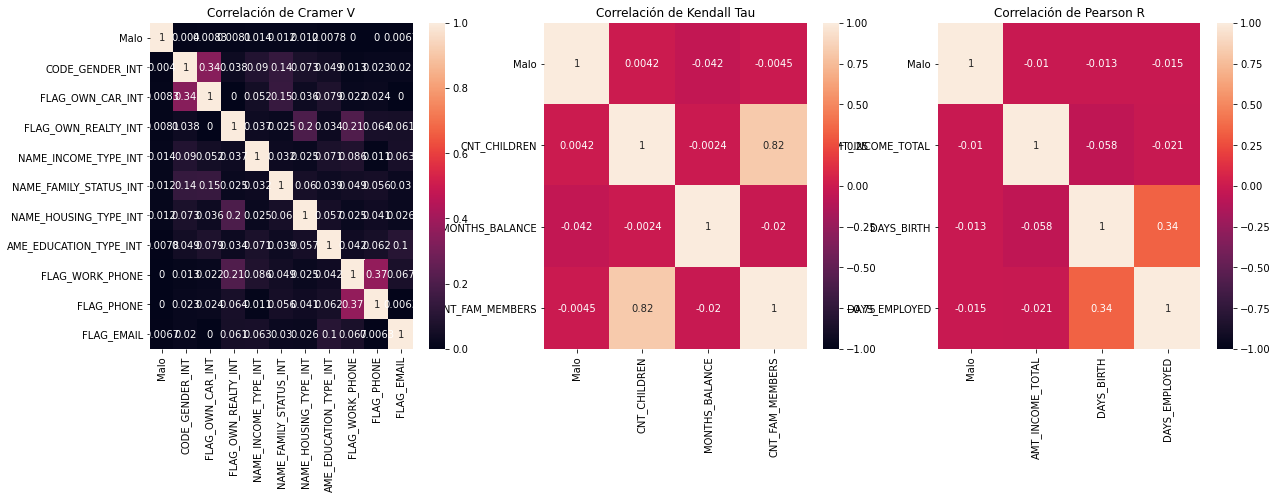

In [44]:
#Ahora calculemos las matricez de correlacion 
fig, axes = plt.subplots(1, 3, figsize=(20,6))
# nominal variable correlation
ax1 = sns.heatmap(v_cramer_matriz(new_data, nom_vars), annot=True, ax=axes[0], vmin=0)
# ordinal variable correlation: 
ax2 = sns.heatmap(new_data[ord_vars].corr(method='kendall'), annot=True, ax=axes[1], vmin=-1)
# Pearson's correlation:
ax3 = sns.heatmap(new_data[cont_vars].corr(), annot=True, ax=axes[2], vmin=-1)

ax1.set_title("Correlación de Cramer V")
ax2.set_title("Correlación de Kendall Tau")
ax3.set_title("Correlación de Pearson R")

# IV & WoE
Para complementar nuestro análisis de correlación calcularemos el “Information Value” y “Weight of Evidence” para cada variable. Esto nos ayudara a explicar las características de un buen y mal cliente.

In [45]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
ivtable

,variable,IV
0,ID,None
1,CODE_GENDER_INT,None
2,FLAG_OWN_CAR_INT,None
3,FLAG_OWN_REALTY_INT,None
4,CNT_CHILDREN,None
5,AMT_INCOME_TOTAL,None
6,NAME_INCOME_TYPE_INT,None
7,AME_EDUCATION_TYPE_INT,None
8,NAME_FAMILY_STATUS_INT,None
9,NAME_HOUSING_TYPE_INT,None


In [46]:
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

ivtable

,variable,IV
1,CODE_GENDER_INT,None
2,FLAG_OWN_CAR_INT,None
3,FLAG_OWN_REALTY_INT,None
4,CNT_CHILDREN,None
5,AMT_INCOME_TOTAL,None
6,NAME_INCOME_TYPE_INT,None
7,AME_EDUCATION_TYPE_INT,None
8,NAME_FAMILY_STATUS_INT,None
9,NAME_HOUSING_TYPE_INT,None
10,DAYS_BIRTH,None


In [47]:
# Calcular valor de la información
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Valor
                    df[df[feature] == val].count()[feature],                        # Todos
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Bueno (cliente no se retrasa)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Malo (cliente se retrasa)

    data = pd.DataFrame(lst, columns=['Variable', 'Valor', 'Todos', 'Bueno', 'Malo'])
    data['Share'] = data['Todos'] / data['Todos'].sum()
    data['Bad Rate'] = data['Malo'] / data['Todos']
    data['Distribucion de bueno'] = (data['Todos'] - data['Malo']) / (data['Todos'].sum() - data['Malo'].sum())
    data['Distribucion de malo'] = data['Malo'] / data['Malo'].sum()
    data['WoE'] = np.log(data['Distribucion de bueno'] / data['Distribucion de malo'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribucion de bueno'] - data['Distribucion de malo'])

    data = data.sort_values(by=['Variable', 'Valor'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('El IV de esta variable es:',iv)
    print(df[feature].value_counts())
    return iv, data

# Selecion de caractericticas Regresion Logistica

In [48]:
#separamaos nuestras variables predictoras y de respuesta
Y = new_data['Malo']
X = new_data.loc[:, ~new_data.columns.isin(['Malo', 'ID','OCCUPATION_TYPE_INT' ])]
#uUtilizamos Synthetic Minority Over-Sampling Technique(SMOTE) para balancear nuestros sets de entrenamiento
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X,Y)

#Cremoas nuestros sets de prueba
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

In [49]:
#escalamos los datos
columnas_nornmalizables = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
#utilizamos una normalizacion robusta para cuidarnos de los datos extremos
#Teniendo cuidado de escalar los datos despues de nuestro split para evitar fuga de información
scaler = preprocessing.RobustScaler()
X_train[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']] = scaler.fit_transform(X_train[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]])
X_test[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']] = scaler.fit_transform(X_test[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]])

<ipython-input-49-5d6bc7813167>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']] = scaler.fit_transform(X_train[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]])
C:\Users\Promethium\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-49-5d6bc7813167>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [54]:
#Utilizamos la funcion de seleccion de mejores caracteristicas
#para enciontrar las variables más representativas
Caracter= SelectKBest(mutual_info_classif, k=8).fit(X_train, y_train)

In [55]:
cols = Caracter.get_support(indices=True)
caracteristicasRep=X_train.iloc[:,cols]

In [56]:
caracteristicasRep

,FLAG_OWN_CAR_INT,AMT_INCOME_TOTAL,NAME_INCOME_TYPE_INT,AME_EDUCATION_TYPE_INT,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_PHONE,MONTHS_BALANCE
37622,1,0.250000,5,5,0.788662,-0.121035,0,-0.243018
7876,2,-0.500000,5,5,0.911524,0.625209,0,-46.000000
25039,1,2.500000,1,5,-0.056877,0.206177,1,-33.000000
14332,2,1.750000,5,5,0.305576,-0.584725,0,-14.000000
14493,2,-0.750000,3,2,0.111152,-0.759182,0,-15.000000
...,...,...,...,...,...,...,...,...
33634,2,-1.000000,5,5,0.662268,0.272120,0,-30.113295
41464,1,0.500000,3,3,-1.295353,-0.432805,0,-34.682022
30939,2,-0.250000,5,5,-0.647026,0.143990,0,-27.987655
43374,1,8.000000,5,5,-0.169145,0.345159,0,-10.905170


In [57]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs',
                           max_iter =10000)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.62964
      0     1
0  4225  2388
1  2510  4102


Tras analizar la correlación entre nuestras variables y la respuesta de nuestro examen de selección por el método de información mutua. Llegamos a la conclusión de que las 7 características más representativas son:
* Genero  
* Ingresos  
* Tipo de ingresos  
* Tipo de educación  
* Dias empleado  
* Cantidad de miembros en la familia
* Edad de la cuenta
A continuación, analizaremos más a detalle las características definidas para entender mejor su comportamiento y buscar las clases que mejor definen a un “buen” cliente.                                                        

# Analisis de las variables selecionadas

In [58]:
#esta funcion nos permite crear con más facilidad las categorías 
#para analizar nuestras variables continuas
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # cortes por quantiles
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # cortes equidistantes
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

# Análisis de género

In [59]:
iv, data = calc_iv(new_data,'CODE_GENDER_INT','Malo')
ivtable.loc[ivtable['variable']=='CODE_GENDER_INT','IV']=iv
data.head()

El IV de esta variable es: 0.0005331304657155266
2    15630
1     9504
Name: CODE_GENDER_INT, dtype: int64


,Variable,Valor,Todos,Bueno,Malo,Share,Bad Rate,Distribucion de bueno,Distribucion de malo,WoE,IV
0,CODE_GENDER_INT,1,9504,1200,8304,0.378133,0.873737,0.387973,0.376752,0.029347,0.000329
1,CODE_GENDER_INT,2,15630,1893,13737,0.621867,0.878887,0.612027,0.623248,-0.018167,0.000204


Text(0, 0.5, 'Número de vencimientos')

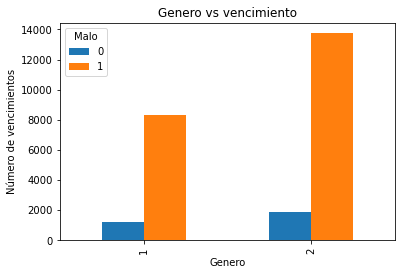

In [60]:
pd.crosstab(new_data.CODE_GENDER_INT,new_data.Malo).plot(kind='bar')
plt.title('Genero vs vencimiento')
plt.xlabel('Genero')
plt.ylabel('Número de vencimientos')

La categoría de genero esta relativamente equilibrada y notamos existe una ligere preferencia hacia los clientes que son hombres. Es importante tener siempre en mente los sesgos que existen a lo largo de todo el proceso de modelaje y captación de datos.  En este caso el modelo discrimina a las mujeres, lo cual es un tema con más trasfondo que el financiero, recomendaría hacer un análisis más complejo a través de todo el proceso de manejo de créditos para poder identificar los sesgos externos que afectan esta medida.                   

# Categoría de ingresos

In [61]:
iv, data = calc_iv(new_data,'NAME_INCOME_TYPE_INT','Malo')
ivtable.loc[ivtable['variable']=='NAME_INCOME_TYPE_INT','IV']=iv
data.head()

El IV de esta variable es: 0.0021321868463111677
5    15622
1     7052
3     2437
2       13
4       10
Name: NAME_INCOME_TYPE_INT, dtype: int64


C:\Users\Promethium\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Variable,Valor,Todos,Bueno,Malo,Share,Bad Rate,Distribucion de bueno,Distribucion de malo,WoE,IV
0,NAME_INCOME_TYPE_INT,1,7052,922,6130,0.280576,0.869257,0.298092,0.278118,0.069358,0.001385
1,NAME_INCOME_TYPE_INT,2,13,0,13,0.000517,1.000000,0.000000,0.000590,0.000000,-0.000000
2,NAME_INCOME_TYPE_INT,3,2437,281,2156,0.096960,0.884694,0.090850,0.097818,-0.073892,0.000515
3,NAME_INCOME_TYPE_INT,4,10,0,10,0.000398,1.000000,0.000000,0.000454,0.000000,-0.000000
4,NAME_INCOME_TYPE_INT,5,15622,1890,13732,0.621549,0.879017,0.611057,0.623021,-0.019389,0.000232


Text(0, 0.5, 'Categoria de ingreso')

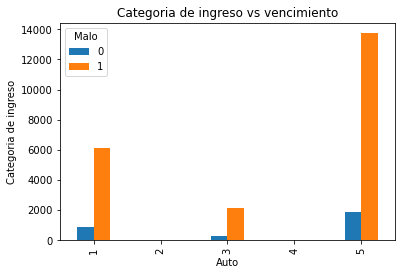

In [62]:
pd.crosstab(new_data.NAME_INCOME_TYPE_INT,new_data.Malo).plot(kind='bar')
plt.title('Categoria de ingreso vs vencimiento')
plt.xlabel('Auto')
plt.ylabel('Categoria de ingreso')

# Tipo de educación

In [63]:
iv, data = calc_iv(new_data,'AME_EDUCATION_TYPE_INT','Malo')
ivtable.loc[ivtable['variable']=='AME_EDUCATION_TYPE_INT','IV']=iv
data.head()

El IV de esta variable es: 0.0016474977850285896
5    16808
2     7132
3      993
4      187
1       14
Name: AME_EDUCATION_TYPE_INT, dtype: int64


,Variable,Valor,Todos,Bueno,Malo,Share,Bad Rate,Distribucion de bueno,Distribucion de malo,WoE,IV
0,AME_EDUCATION_TYPE_INT,1,14,4,10,0.000557,0.714286,0.001293,0.000454,1.047472,0.000879
1,AME_EDUCATION_TYPE_INT,2,7132,908,6224,0.283759,0.872686,0.293566,0.282383,0.038839,0.000434
2,AME_EDUCATION_TYPE_INT,3,993,116,877,0.039508,0.883182,0.037504,0.039789,-0.059154,0.000135
3,AME_EDUCATION_TYPE_INT,4,187,21,166,0.007440,0.887701,0.006790,0.007531,-0.103702,0.000077
4,AME_EDUCATION_TYPE_INT,5,16808,2044,14764,0.668736,0.878391,0.660847,0.669843,-0.013520,0.000122


Text(0, 0.5, 'Número de vencimientos')

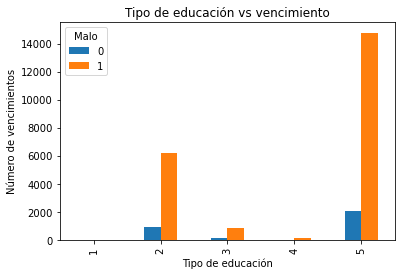

In [64]:
pd.crosstab(new_data.AME_EDUCATION_TYPE_INT,new_data.Malo).plot(kind='bar')
plt.title('Tipo de educación vs vencimiento')
plt.xlabel('Tipo de educación')
plt.ylabel('Número de vencimientos')

# Cantidad de integrantes de familia

In [65]:
iv, data = calc_iv(new_data,'CNT_FAM_MEMBERS','Malo')
ivtable.loc[ivtable['variable']=='CNT_FAM_MEMBERS','IV']=iv
data

El IV de esta variable es: 0.0077037895266118895
2     12697
3      5216
1      4263
4      2576
5       307
6        51
7        18
15        3
9         2
20        1
Name: CNT_FAM_MEMBERS, dtype: int64


C:\Users\Promethium\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Variable,Valor,Todos,Bueno,Malo,Share,Bad Rate,Distribucion de bueno,Distribucion de malo,WoE,IV
0,CNT_FAM_MEMBERS,1,4263,486,3777,0.169611,0.885996,0.157129,0.171362,-0.086714,0.001234
1,CNT_FAM_MEMBERS,2,12697,1591,11106,0.505172,0.874695,0.514387,0.503879,0.020640,0.000217
2,CNT_FAM_MEMBERS,3,5216,690,4526,0.207528,0.867715,0.223084,0.205345,0.082861,0.001470
3,CNT_FAM_MEMBERS,4,2576,280,2296,0.102491,0.891304,0.090527,0.104170,-0.140371,0.001915
4,CNT_FAM_MEMBERS,5,307,30,277,0.012215,0.902280,0.009699,0.012567,-0.259057,0.000743
5,CNT_FAM_MEMBERS,6,51,12,39,0.002029,0.764706,0.003880,0.001769,0.785108,0.001657
6,CNT_FAM_MEMBERS,7,18,4,14,0.000716,0.777778,0.001293,0.000635,0.711000,0.000468
7,CNT_FAM_MEMBERS,9,2,0,2,0.000080,1.000000,0.000000,0.000091,0.000000,-0.000000
8,CNT_FAM_MEMBERS,15,3,0,3,0.000119,1.000000,0.000000,0.000136,0.000000,-0.000000
9,CNT_FAM_MEMBERS,20,1,0,1,0.000040,1.000000,0.000000,0.000045,0.000000,-0.000000


Text(0, 0.5, 'Número de vencimientos')

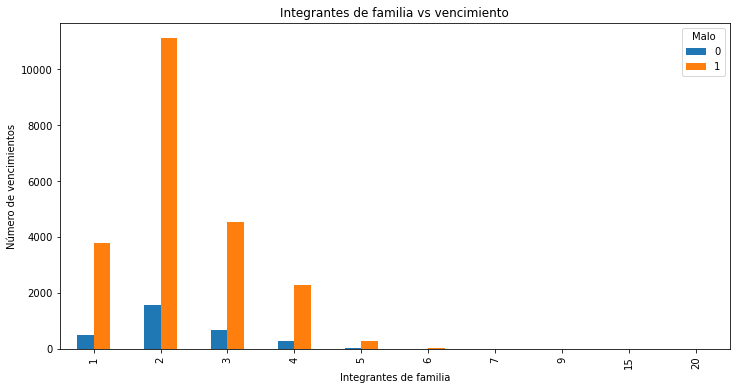

In [66]:
pd.crosstab(new_data.CNT_FAM_MEMBERS,new_data.Malo).plot(kind='bar', figsize=(12,6))
plt.title('Integrantes de familia vs vencimiento')
plt.xlabel('Integrantes de familia')
plt.ylabel('Número de vencimientos')

# Duarcion de empleo

<AxesSubplot:ylabel='Frequency'>

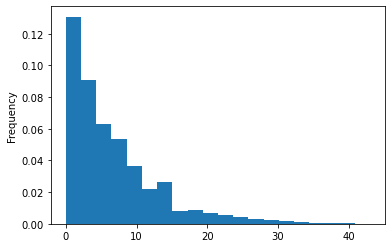

In [67]:
#primero debemos de separar nuestra varibale continua en grupos para analñizar
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [68]:
new_data = get_category(new_data,'worktm',5, ["mas bajo","bajo","mediano","alto","mas alto"])

In [69]:

iv, data=calc_iv(new_data,'gp_worktm','Malo')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

El IV de esta variable es: 0.0029233360958798808
mas bajo    18254
bajo         4987
mediano      1378
alto          425
mas alto       90
Name: gp_worktm, dtype: int64


,Variable,Valor,Todos,Bueno,Malo,Share,Bad Rate,Distribucion de bueno,Distribucion de malo,WoE,IV
0,gp_worktm,alto,425,48,377,0.016909,0.887059,0.015519,0.017104,-0.097281,0.000154
1,gp_worktm,bajo,4987,577,4410,0.198416,0.884299,0.186550,0.200082,-0.070025,0.000948
2,gp_worktm,mas alto,90,12,78,0.003581,0.866667,0.003880,0.003539,0.091961,0.000031
3,gp_worktm,mas bajo,18254,2307,15947,0.726267,0.873617,0.745878,0.723515,0.030440,0.000681
4,gp_worktm,mediano,1378,149,1229,0.054826,0.891872,0.048173,0.055760,-0.146247,0.001109


# Ingresos

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: AMT_INCOME_TOTAL, dtype: int64


<AxesSubplot:ylabel='Frequency'>

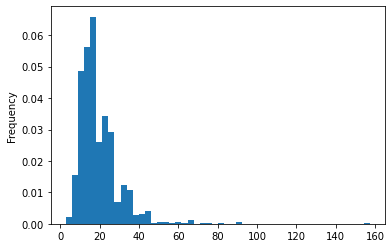

In [70]:
new_data['AMT_INCOME_TOTAL']=new_data['AMT_INCOME_TOTAL'].astype(object)
new_data['AMT_INCOME_TOTAL'] = new_data['AMT_INCOME_TOTAL']/10000 
print(new_data['AMT_INCOME_TOTAL'].value_counts(bins=10,sort=False))
new_data['AMT_INCOME_TOTAL'].plot(kind='hist',bins=50,density=True)

In [71]:
new_data = get_category(new_data,'AMT_INCOME_TOTAL', 3, ["bajo","medio", "alto"], qcut = True)

In [72]:
iv, data = calc_iv(new_data,'gp_AMT_INCOME_TOTAL','Malo')
ivtable.loc[ivtable['variable']=='AMT_INCOME_TOTAL','IV']=iv
data.head()

El IV de esta variable es: 0.002002064181003835
bajo     8996
alto     8244
medio    7894
Name: gp_AMT_INCOME_TOTAL, dtype: int64


,Variable,Valor,Todos,Bueno,Malo,Share,Bad Rate,Distribucion de bueno,Distribucion de malo,WoE,IV
0,gp_AMT_INCOME_TOTAL,alto,8244,1052,7192,0.328002,0.872392,0.340123,0.326301,0.041487,0.000573
1,gp_AMT_INCOME_TOTAL,bajo,8996,1050,7946,0.357922,0.883281,0.339476,0.360510,-0.060116,0.001264
2,gp_AMT_INCOME_TOTAL,medio,7894,991,6903,0.314077,0.874462,0.320401,0.313189,0.022766,0.000164


In [73]:
ivtable

,variable,IV
1,CODE_GENDER_INT,0.000533
2,FLAG_OWN_CAR_INT,None
3,FLAG_OWN_REALTY_INT,None
4,CNT_CHILDREN,None
5,AMT_INCOME_TOTAL,0.002002
6,NAME_INCOME_TYPE_INT,0.002132
7,AME_EDUCATION_TYPE_INT,0.001647
8,NAME_FAMILY_STATUS_INT,None
9,NAME_HOUSING_TYPE_INT,None
10,DAYS_BIRTH,None


In [ ]:

+